In [174]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import re
import random
import torch
from transformers import BertTokenizer, BertModel
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

# random.seed(42)
# tf.random.set_seed(42)
# np.random.seed(42)

In [175]:
MODEL_NAME = 'bert-base-uncased'
MAX_SEQ_LENGHT = 50

In [176]:

df = pd.read_excel('Data/drugData.xlsx')
# df = pd.read_excel('Data/Data_drug_all.xlsx')
df.head()

,Unnamed: 0,name,text,MOA
0,0,AAB-003,\n\nAAB-003 is a humanized version of the anti...,4
1,1,AADvac1,\n\nThis is an active vaccine designed to elic...,4
2,2,AAVrh.10-APOE2,\n\nThis gene-therapy approach uses a viral ve...,4
3,3,ABBV-0805,\n\n\nABBV-0805 is a humanized monoclonal anti...,4
4,4,ABBV-8E12,\nC2N 8E12 is a humanized IgG4 antibody being ...,4


In [177]:
labels = df['MOA'].apply(lambda x: 0 if x == 4 else 1)

NUM_LABEL = len(labels.unique())
labels = to_categorical(labels)


In [178]:
print('There are {} records in the dataset'.format(df.shape[0]))

There are 233 records in the dataset


In [179]:
df['text'] = df['text'].apply(lambda x: x.replace('\n\n', ''))

In [180]:
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)
bert = BertModel.from_pretrained(MODEL_NAME)

In [181]:
LEARNING_RATE = 0.01


model = tf.keras.Sequential([
        tf.keras.layers.Input((bert.config.hidden_size,), name='input_layer'),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Dense(bert.config.hidden_size, activation='relu', name='dense_1'),
        tf.keras.layers.Dense(bert.config.hidden_size/2, activation='relu', name='dense_2'),
        tf.keras.layers.Dense(bert.config.hidden_size/4, activation='relu', name='dense_3'),
        tf.keras.layers.Dense(bert.config.hidden_size/8, activation='relu', name='dense_4'),
        tf.keras.layers.Dense(NUM_LABEL, name='dense_5'),
        tf.keras.layers.Activation('softmax', name='softmax')
])

opt = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_5 (Dropout)          (None, 768)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 768)               590592    
_________________________________________________________________
dense_2 (Dense)              (None, 384)               295296    
_________________________________________________________________
dense_3 (Dense)              (None, 192)               73920     
_________________________________________________________________
dense_4 (Dense)              (None, 96)                18528     
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 194       
_________________________________________________________________
softmax (Activation)         (None, 2)                

In [182]:
def convert_lines(example, max_seq_length,tokenizer):
    max_seq_length -=2
    all_windows = []

    for text in tqdm(example):
        windows = []
        tokens_a = tokenizer.tokenize(text)
        for i in range(0, len(tokens_a), max_seq_length):
            window = tokenizer.convert_tokens_to_ids(["[CLS]"] + tokens_a[i:i + max_seq_length] + ["[SEP]"])+ \
                                                            [0] * (max_seq_length - len(tokens_a))
            windows.extend(window)
        all_windows.append(windows)
        
    return np.array(all_windows)

In [183]:
tokenized = convert_lines(df['text'], MAX_SEQ_LENGHT, tokenizer)

<ipython-input-182-4b152568a91f>:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(all_windows)


In [184]:
cls_features = []
for tokens in tqdm(tokenized):
    CLS = torch.zeros(1,768)
    for i in range(0, len(tokens), MAX_SEQ_LENGHT):
        batch = tokens[i:i + MAX_SEQ_LENGHT]
        if len(tokens) < MAX_SEQ_LENGHT:
            batch = np.pad(batch, (0,MAX_SEQ_LENGHT-len(batch)), 'constant')
        batch = torch.tensor(batch).unsqueeze(0)
            
        CLS += bert(batch)[0][:,0,:]
        
    cls_features.append(CLS)

In [185]:
cls_features = [c.tolist() for c in cls_features]
cls_features = np.array(cls_features)
cls_features.shape

(233, 1, 768)

In [186]:
cls_features = cls_features.squeeze(1)

In [187]:


X_train, X_test, y_train, y_test = train_test_split(cls_features, labels, test_size=0.25) 

In [188]:
# class_weight = {0: 5.5,
#                 1: 6.25,
#                 2:1.4,
#                3:1}

In [192]:
model.fit(X_train, y_train, batch_size=15, epochs=50)

Epoch 1/50
12/12 [==============================] - 0s 5ms/step - loss: 0.3362 - accuracy: 0.9425
Epoch 2/50
12/12 [==============================] - 0s 5ms/step - loss: 0.1109 - accuracy: 0.9770
Epoch 3/50
12/12 [==============================] - 0s 5ms/step - loss: 0.1958 - accuracy: 0.9253
Epoch 4/50
12/12 [==============================] - 0s 5ms/step - loss: 0.1960 - accuracy: 0.9483
Epoch 5/50
12/12 [==============================] - 0s 5ms/step - loss: 0.1061 - accuracy: 0.9828
Epoch 6/50
12/12 [==============================] - 0s 5ms/step - loss: 0.1129 - accuracy: 0.9655
Epoch 7/50
12/12 [==============================] - 0s 4ms/step - loss: 0.1454 - accuracy: 0.9655
Epoch 8/50
12/12 [==============================] - 0s 4ms/step - loss: 0.1121 - accuracy: 0.9655
Epoch 9/50
12/12 [==============================] - 0s 5ms/step - loss: 0.2435 - accuracy: 0.9195
Epoch 10/50
12/12 [==============================] - 0s 5ms/step - loss: 0.2495 - accuracy: 0.9023
Epoch 11/50
12/12 [

In [193]:
res = model.predict(X_test)
y_pred = np.argmax(res, axis=1)

In [194]:
print('The accuracy is {:0.02f}%'.format(accuracy_score(np.argmax(y_test, axis=1), y_pred)*100))

The accuracy is 89.83%


<AxesSubplot:>

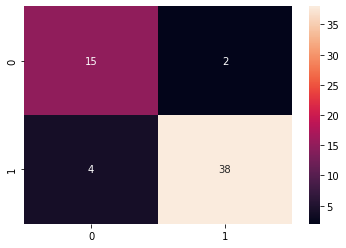

In [195]:
sns.heatmap(confusion_matrix(np.argmax(y_test, axis=1), y_pred), annot=True)

In [97]:
from sklearn.metrics import precision_score, recall_score, f1_score
print('The precision of the model: {:0.02f}%'.format(precision_score(np.argmax(y_test, axis=1), y_pred, average='micro')))
print('The recall of the model: {:0.02f}%'.format(recall_score(np.argmax(y_test, axis=1), y_pred,  average='micro')))
print('The f1 score of the model: {:0.02f}%'.format(f1_score(np.argmax(y_test, axis=1), y_pred, average='micro')))

The precision of the model: 0.64%
The recall of the model: 0.64%
The f1 score of the model: 0.64%
